In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import KMeans

# Data Manipulation

After loading the dataset and dropping the NaN values, we are left with 28625 observations over 25 features. However, I want to remove some values which I found to be incorrect data. Artists that have very little followers, but are present on the charts, are most likely API errors, especially the newer artists. I will remove rows that have songs released after 2000 from artists with 10000 Spotify followers. This leaves us with 28364 observations, which is a pretty small loss.

In [4]:
songs = pd.read_csv("data/filled_artists_info.csv", index_col = 0).dropna()
songs.shape

(28625, 25)

In [5]:
songs = songs[~((songs["artist_followers"] < 10000) & (songs["year"] >= 2000))].reset_index(drop=True)
songs.shape

(28364, 25)

In [6]:
songs.describe()

,peak_position,weeks_on_chart,year,track_duration_s,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spotify_popularity,artist_popularity,artist_followers
count,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,2.836400e+04
mean,45.372303,11.296503,1989.581406,218.226595,0.603875,0.615910,5.219927,-8.601705,0.720491,0.078557,0.296235,0.034020,0.193157,0.594486,120.477352,41.734170,59.111092,7.893928e+06
std,30.275325,8.674580,20.766197,67.794734,0.154076,0.196853,3.568323,3.581029,0.448766,0.088631,0.283728,0.140585,0.158985,0.241217,28.210072,23.073346,21.804601,2.009475e+07
min,1.000000,1.000000,1958.000000,27.133000,0.000000,0.000581,0.000000,-37.326000,0.000000,0.000000,0.000002,0.000000,0.009670,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,17.000000,4.000000,1970.000000,172.438500,0.503000,0.477000,2.000000,-10.919250,0.000000,0.032500,0.046500,0.000000,0.092600,0.402000,99.028500,22.000000,45.000000,1.083650e+05
50%,44.000000,10.000000,1987.000000,212.000000,0.611000,0.631000,5.000000,-8.110500,1.000000,0.042500,0.194000,0.000004,0.132000,0.611000,119.306000,44.000000,62.000000,9.880820e+05
75%,71.000000,17.000000,2009.000000,250.760000,0.713000,0.771000,8.000000,-5.837000,1.000000,0.073900,0.515000,0.000417,0.249000,0.798000,137.279750,60.000000,75.000000,5.390632e+06
max,100.000000,91.000000,2024.000000,3079.157000,0.988000,0.997000,11.000000,2.291000,1.000000,0.951000,0.996000,0.982000,0.999000,0.991000,241.009000,100.000000,100.000000,1.263410e+08


## Feature Engineering

My first goal is to add a feature that will be a calculation of the total songs that each artist has on the chart. It is a feature that I think will be pretty useful in deciding the popularity of songs, as artists with a lot of songs on the chart are of course more likely to also chart at higher positions.

In [8]:
songs["total_songs_for_artist"] = songs.groupby("main_artist")["song"].transform("count")

In [9]:
songs.groupby("main_artist")["total_songs_for_artist"].max().sort_values(ascending=False).head(20)

main_artist
Taylor Swift                  255
Drake                         232
Glee Cast                     206
Future                        123
Elvis Presley                  93
Beyonce                        92
Eminem                         89
Lil Baby                       89
YoungBoy Never Broke Again     88
Kanye West                     86
Justin Bieber                  78
James Brown                    78
The Weeknd                     72
Ariana Grande                  71
Lil Uzi Vert                   70
Lil Wayne                      69
The Beatles                    68
Bad Bunny                      68
Rod Wave                       66
Aretha Franklin                65
Name: total_songs_for_artist, dtype: int64

We can see that there are some artists that have charter a total of above 200 songs. This is likely going to positively influence later predictions, as for example a song from Taylor Swift is very likely to perform good on the chart, considering how many songs she has charted in total.

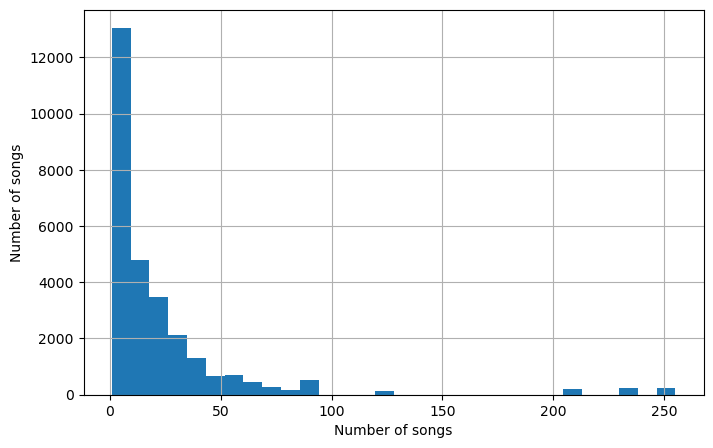

In [11]:
plt.figure(figsize=(8,5))
songs["total_songs_for_artist"].hist(bins=30)

plt.xlabel("Number of songs")
plt.ylabel("Number of songs")

plt.show()

The data is again heavily right skewed, like some other features



Now, two other features will be created. `artist_hit_count` will show the number of top 10 hits for the main artist for each song.
The other one will be `good_performing_artist`. It is an indicator of whether an artist has had more than 10 songs on the chart, from which at least 1 has reached the top 10.

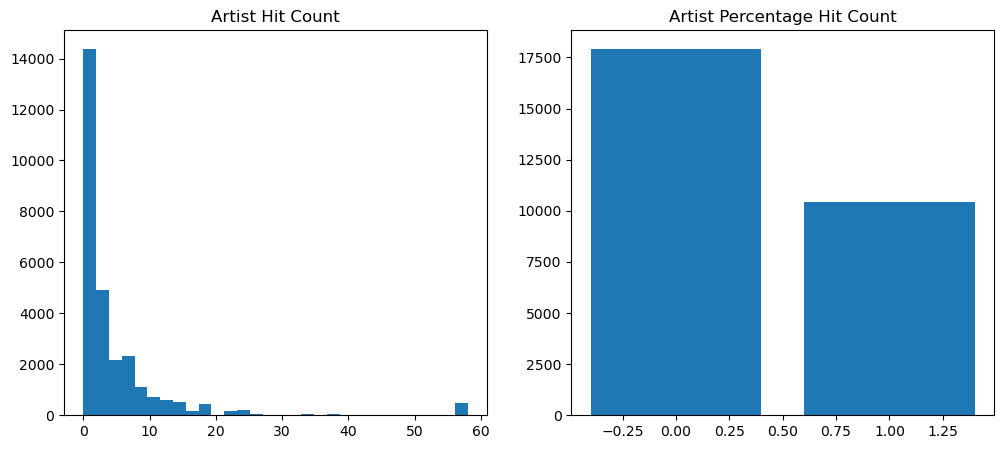

In [14]:
songs["artist_hit_count"] = songs.groupby("main_artist")["peak_position"].transform(lambda x: (x <= 10).sum())
songs["good_performing_artist"] = ((songs["total_songs_for_artist"] >= 10) & 
                            ((songs["artist_hit_count"] / songs["total_songs_for_artist"]) > 0.1)).astype(int)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].hist(songs["artist_hit_count"], bins=30)
axs[0].set_title('Artist Hit Count')

counts = songs["good_performing_artist"].value_counts()
axs[1].bar(counts.index, counts.values)
axs[1].set_title('Artist Percentage Hit Count')

plt.show()

The `artist_hit_count` feature is also heavily right skewed. The `good_performing_artist` is not very uneven, but we have to keep in mind that each song can have this indicator, meaning that when an artist is charting good and has a lot of songs on the chart, this will lead to a increase in the `1` class equal to the number of songs that the artist has.

I also want to add a feature that indicates whether the song is a top 10 hit or not, which will be used as the target for future models to predict. The data must first be scaled before adding that new feature.

In [17]:
top_10_hit = songs['peak_position'].apply(lambda x: 1 if x <= 10 else 0)

## Data Transformation

As previously established, many features contain a lot of outliers, especially `instrumentalness`, `weeks_on_chart`, `track_duration_s`, `loudness`, `liveness`, `artist_followers` and now also `total_songs_for_artist`.
I want to first transform these columns using either logarithmic or square root scaling. Logarithmic scaling is useful for transforming right skewed data, while square root will help me transform features with ranges between 0 and 1, as logarithic scaling doesn't work on them.

First I will have to treat the loudness column, as it contains negative values, which prevents me from preventing either of these transformations on it. I will tranfrom them first by making the minimum value be zero.

In [19]:
min_value = songs['loudness'].min()
songs['loudness'] = songs['loudness'] - min_value

In [20]:
songs["loudness"].describe()

count    28364.000000
mean        28.724295
std          3.581029
min          0.000000
25%         26.406750
50%         29.215500
75%         31.489000
max         39.617000
Name: loudness, dtype: float64

Now lets select the numerical columns, then the columns that need to be scaled and apply the scaling. I will also drop the `mode` and `key` columns, as they contain categorical data, which can't be treated in the same way.

In [22]:
numeric_data = songs.select_dtypes(include="number")
numeric_data = numeric_data.drop(columns=["key", "mode"])

In [23]:
log_scale_columns = ["weeks_on_chart", "track_duration_s", "artist_followers"]
sqrt_scale_columns = ["loudness", "liveness", "tempo", "instrumentalness"]

In [24]:
numeric_data[log_scale_columns] = np.log1p(numeric_data[log_scale_columns])
numeric_data[sqrt_scale_columns] = np.sqrt(numeric_data[sqrt_scale_columns])

Also, I will have to get the inverse of the position, as currently a number 1 song will be considered as being the lowest in the chart, instead of the highest. By substracting the position from 101, I will effectively get the inverse value as now 1 will be 100 and 100 will be 1.

In [26]:
numeric_data["peak_position"] = 101 - numeric_data["peak_position"]

As previously mentioned, after performing these transformations, the features still contain a lot of outliers. Now I will also perform value clipping on the audio feature and spotify metrics that need it.

The clipping will be performed using the Interquartile Range (IQR). IQR represents the value between the first and the third quartile (25% and 75% of the data). A popular method for performing this type of data clipping is to select upper and lower bounds by using 1.5 times the IQR.

In [28]:
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
lower_bound = Q1 - 1.5 * (Q3 - Q1)
upper_bound = Q3 + 1.5 * (Q3 - Q1)

In [29]:
scaled_data = numeric_data.clip(lower_bound, upper_bound, axis=1)
scaled_data.describe()

,peak_position,weeks_on_chart,year,track_duration_s,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spotify_popularity,artist_popularity,artist_followers,total_songs_for_artist,artist_hit_count,good_performing_artist
count,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000,28364.000000
mean,55.627697,2.229132,1989.581406,5.349177,0.603995,0.615920,5.352118,0.059984,0.296235,0.013338,0.408635,0.594486,10.902222,41.734170,59.111092,13.317852,17.947821,3.248872,0.367896
std,30.275325,0.807988,20.766197,0.271537,0.153724,0.196824,0.331461,0.037649,0.283728,0.019530,0.146521,0.241217,1.273191,23.073346,21.804601,2.993299,17.934729,4.013657,0.482241
min,1.000000,0.693147,1958.000000,4.596843,0.188000,0.036000,4.429616,0.000000,0.000002,0.000000,0.098336,0.000000,7.303300,0.000000,0.000000,5.732914,1.000000,0.000000,0.000000
25%,30.000000,1.609438,1970.000000,5.155823,0.503000,0.477000,5.138750,0.032500,0.046500,0.000000,0.304302,0.402000,9.951306,22.000000,45.000000,11.593270,4.000000,0.000000,0.000000
50%,57.000000,2.397895,1987.000000,5.361292,0.611000,0.631000,5.405136,0.042500,0.194000,0.002000,0.363318,0.611000,10.922729,44.000000,62.000000,13.803522,11.000000,1.000000,0.000000
75%,84.000000,2.890372,2009.000000,5.528476,0.713000,0.771000,5.611506,0.073900,0.515000,0.020421,0.498999,0.798000,11.716644,60.000000,75.000000,15.500173,26.000000,5.000000,1.000000
max,100.000000,4.521789,2024.000000,6.087456,0.988000,0.997000,6.294204,0.136000,0.996000,0.051051,0.791044,0.991000,14.364651,100.000000,100.000000,18.654495,59.000000,12.500000,1.000000


Now the outliers should be properly treated. It's time to scale the values using a `MinMaxScaler` and take a final look at the distributions of the features 

In [31]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(scaled_data)
scaled_data = pd.DataFrame(mm_scaler.transform(scaled_data), columns=scaled_data.columns)

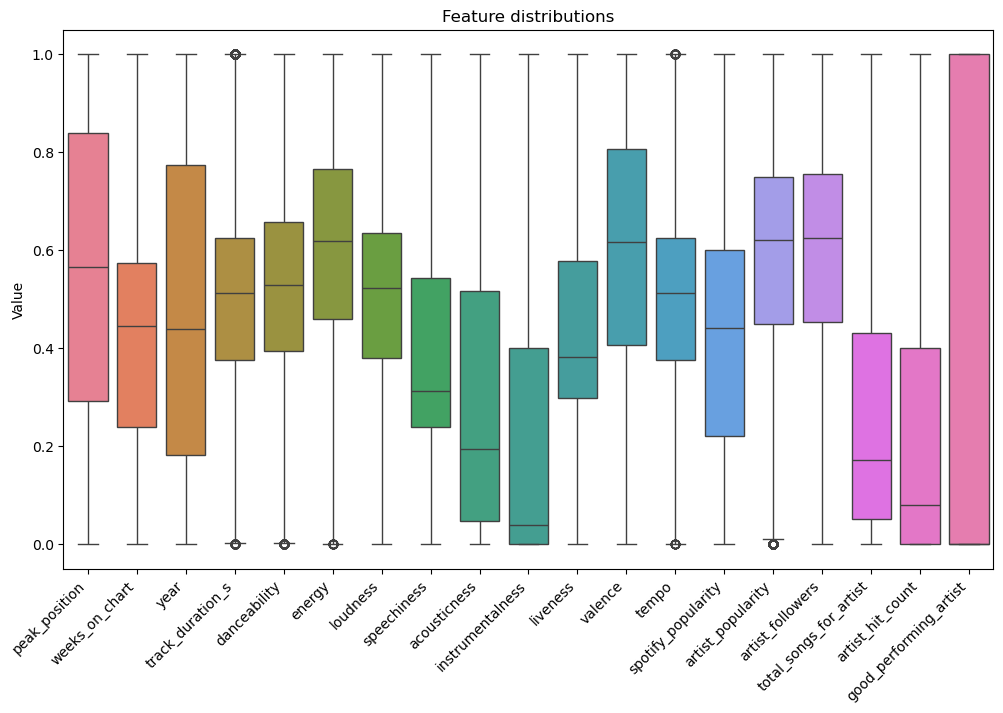

In [32]:
plt.figure(figsize=(12,7))
sns.boxplot(scaled_data)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Value")
plt.title("Feature distributions")

plt.show()

Now the **top_10** feature can be added.

In [34]:
scaled_data["top_10_hit"] = top_10_hit

# Clustering

Now that the data has been properly scaled, it is time to move on to creating the new cluster-based feature. 

I will group the songs into separate clusters based on their audio features and then measure the average popularity of each cluster. The goal is to see if the clusters naturally manage group the songs into different popularity brackets. For this purpose I will select only the columns that contain the year and the audio features, excluding everything else related to the song's or artist's popularity.

In [36]:
# Select only columns from year to tempo
cluster_features = scaled_data.iloc[:, 2:12]

Before actually applying clustering, I will use the **elbow method** to find a suitable number of clusters.

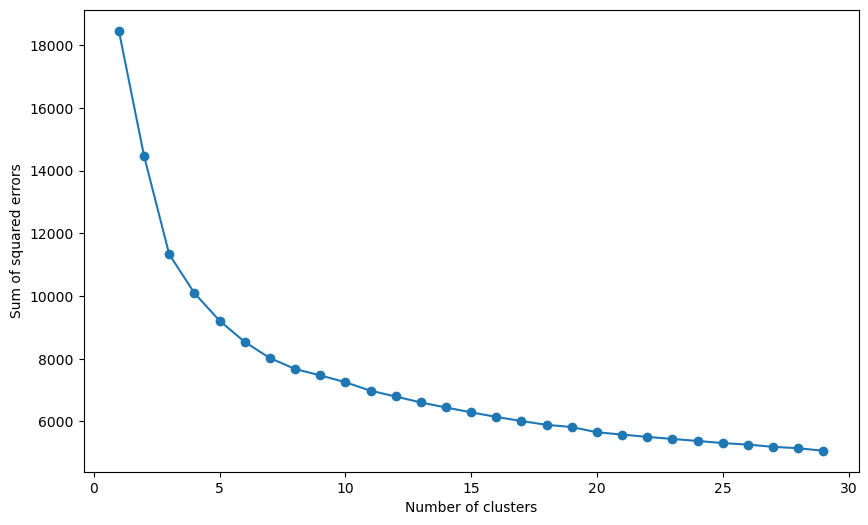

In [38]:
distortion = []
for k in range(1,30):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans.fit_predict(cluster_features)
    distortion.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,30), distortion, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared errors")
plt.show()

There isn't really a well defined elbow. After around 5 clusters, the decrease of sum of squared errors does slow down a little, but continues to noticably decline, while the sum is very high. This means that the clusters are not very well defined.

This will not be that big of a problem, as I can still select a high number of clusters (but also not that high as to not have too few songs in each cluster) to evaluate what percentage of songs in each cluster are a top 10 hit. This will be just a new feature, which will hopefully have a correlation with the target variable.

After trying different number of clusters, I came to the conclusion that the correlation with the target variable starts to stagnate after 17 clusters. For this purpose I will use `KMeans` with `n_clusters=17`. I will also use a higher number of initializaitions (**n_init=5**).

In [40]:
kmeans = KMeans(n_clusters=17, random_state=42, n_init=5, init="random")
cluster = kmeans.fit_predict(cluster_features)

After initializing the clusters, I will group the songs of my `scaled_data` dataframe, by the cluster, in which they are located.

In [42]:
scaled_data["cluster"] = cluster
grouped_clusters = scaled_data.groupby("cluster").mean()

In [43]:
grouped_clusters

,peak_position,weeks_on_chart,year,track_duration_s,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spotify_popularity,artist_popularity,artist_followers,total_songs_for_artist,artist_hit_count,good_performing_artist,top_10_hit
cluster,,,,,,,,,,,,,,,,,,,,
0,0.521107,0.364087,0.237979,0.475594,0.323540,0.292680,0.243252,0.274573,0.739719,0.934916,0.444809,0.368642,0.440582,0.292024,0.515664,0.496897,0.274101,0.247688,0.381616,0.161560
1,0.558485,0.373709,0.154423,0.377668,0.500898,0.636624,0.441823,0.899893,0.482966,0.057382,0.531688,0.758713,0.556373,0.237085,0.438788,0.423625,0.244041,0.221126,0.359307,0.200577
2,0.594898,0.439395,0.316845,0.525985,0.588122,0.670608,0.457373,0.319730,0.143832,0.103597,0.307829,0.815281,0.516590,0.329443,0.511799,0.506561,0.223235,0.261182,0.399402,0.233358
3,0.619982,0.473163,0.363040,0.626745,0.414330,0.458178,0.376552,0.263525,0.273557,0.093880,0.371827,0.414327,0.501153,0.377033,0.538161,0.542535,0.236134,0.288722,0.440139,0.250434
4,0.532669,0.351459,0.808969,0.544747,0.434693,0.398349,0.497103,0.305532,0.653298,0.059995,0.394409,0.338932,0.477644,0.583591,0.729075,0.728304,0.419216,0.316333,0.375105,0.134567
5,0.546611,0.446548,0.807163,0.499584,0.602389,0.770514,0.674563,0.357510,0.120341,0.048238,0.403882,0.716727,0.518239,0.592932,0.712246,0.719593,0.316461,0.233672,0.315508,0.153298
6,0.515487,0.349409,0.781779,0.566100,0.548745,0.762626,0.645343,0.922936,0.126060,0.036508,0.762280,0.561339,0.533034,0.562340,0.727498,0.734590,0.387513,0.326468,0.416170,0.139574
7,0.540671,0.363587,0.126887,0.331313,0.429024,0.575631,0.456498,0.310759,0.531451,0.061736,0.793023,0.748523,0.511592,0.222563,0.460284,0.445812,0.259494,0.248350,0.409056,0.165004
8,0.575750,0.452385,0.374666,0.654851,0.599425,0.707157,0.444459,0.364981,0.102401,0.945815,0.385339,0.773593,0.516750,0.363407,0.515609,0.515829,0.179837,0.219297,0.320453,0.206089


The top 10 hits percentage of the cluster varies from around 10 to 24%. This is enough of a difference to say that the clusters managed to somewhat successfully separate separate popular songs. This means that there are more hits among songs with certain combination, compared to other combinations.

Now I will map the percentage that I got for each cluster to each song in the dataset.

In [45]:
popularity_dict = dict(zip(grouped_clusters.index, grouped_clusters['top_10_hit']))

# Map the popularity score to the data DataFrame
scaled_data['cluster_hit_pct'] = scaled_data['cluster'].map(popularity_dict)

# Correlations with new features

Now lets evaluate how the new features relate to the target variable `top_10_hit`.



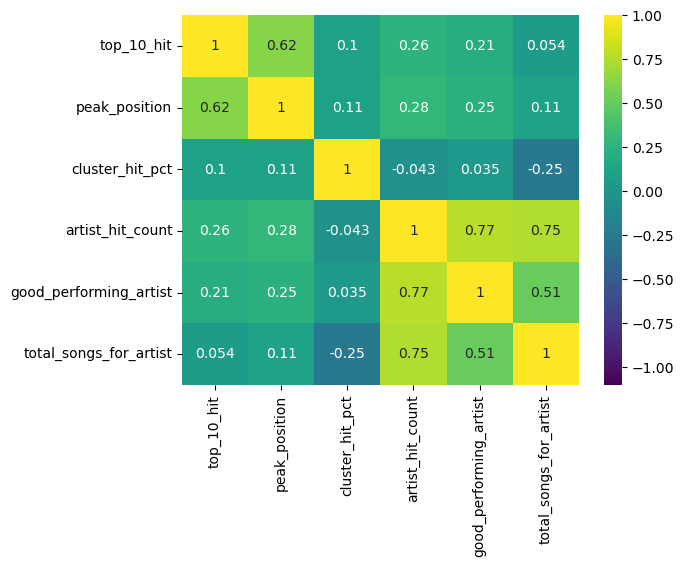

In [48]:
sns.heatmap(
    scaled_data[
        ["top_10_hit", "peak_position", "cluster_hit_pct", "artist_hit_count", "good_performing_artist", "total_songs_for_artist"]
    ].corr(),
    vmin=1, vmax=-1, cmap="viridis", annot=True
)
plt.show()

The cluster-based feature has a score of around 0.11. This is a relatively small correlation with the `top_10_hit`, but it can still prove to be useful when trying to predict hits. The `good_performing_artist` feature, which indicates if an artist has more than 10 songs on the chart and more than 10% of them are in the top 10, has a decent correlation with the target.

### Final Notes

`artist_hit_count` also has a good enough correation with `top_10_hit`, but I find it to be problematic, paired with `total_songs_for_artist`. An artist that has 1 song on the chart, which is also a top 10 hit, automatically means that the hit count for the artist will also be one. This means that if song count is 1 and hit count is 1, a model will instantly recognize that a song is a top 10 hit, which is a dangerous data leakage. For this reason I will drop the `artist_hit_count` and keep only `good_performing_artist` and the total songs count.

The `mode` feature will also be added back into the data, as it didn't have to be preprocessed in any way and was dropped earlier in order to not disort clustering, due to it being a categorical column

In [50]:
scaled_data = scaled_data.drop(columns=["artist_hit_count", "cluster"]) #Also drop the unneeded cluster indication
scaled_data["mode"] = songs["mode"]

In [51]:
scaled_data

,peak_position,weeks_on_chart,year,track_duration_s,danceability,energy,loudness,speechiness,acousticness,instrumentalness,...,valence,tempo,spotify_popularity,artist_popularity,artist_followers,total_songs_for_artist,good_performing_artist,top_10_hit,cluster_hit_pct,mode
0,1.000000,0.573891,1.0,0.370547,0.66750,0.700312,0.675954,0.200735,0.063552,0.000000,...,0.609485,0.240374,0.91,0.80,0.608628,0.000000,0.0,1,0.153298,1.0
1,1.000000,0.508251,1.0,0.396942,0.56250,0.852237,0.680192,0.194118,0.007598,0.000000,...,0.737639,0.567850,0.93,0.91,0.921535,1.000000,1.0,1,0.153298,1.0
2,1.000000,0.526271,1.0,0.684702,0.88750,0.453694,0.577714,0.570588,0.010741,0.000000,...,0.215943,0.389389,0.95,0.91,0.898979,0.879310,1.0,1,0.104735,1.0
3,0.979798,0.573891,1.0,0.386583,0.64125,0.753382,0.650968,0.209559,0.107428,0.158409,...,0.696266,0.409726,0.98,0.94,0.836027,0.068966,0.0,1,0.153298,1.0
4,0.989899,0.543128,1.0,0.304559,0.83000,0.687825,0.648972,0.322794,0.097689,0.376784,...,0.927346,0.629522,0.94,0.78,0.604582,0.017241,0.0,1,0.153298,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28359,0.202020,0.000000,0.0,0.331544,0.43250,0.798127,0.472206,0.546324,0.743975,0.152988,...,0.977800,0.801196,0.75,0.70,0.681877,0.310345,1.0,0,0.165004,1.0
28360,0.191919,0.000000,0.0,0.176417,0.77000,0.661811,0.296394,0.358824,0.780120,0.087601,...,0.955600,0.447692,0.19,0.70,0.681877,0.310345,1.0,0,0.180948,1.0
28361,0.141414,0.000000,0.0,0.300344,0.06750,0.416233,0.551939,0.269853,0.660642,0.000000,...,0.348133,0.143637,0.44,0.56,0.565504,0.741379,1.0,0,0.182830,1.0
28362,0.040404,0.000000,0.0,0.227917,0.49000,0.468262,0.414970,0.255147,0.764056,0.589273,...,0.824420,0.260481,0.21,0.49,0.319055,0.000000,0.0,0,0.173913,0.0


In [52]:
# Export the preprocessed and engineered data
scaled_data.to_csv("data/preprocessed_data.csv")